In [565]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd

In [566]:
data = pd.read_csv('./data/train.csv')
print("rows:", len(data))
print("bad columns below!!!")
bad_columns = data.columns[data.isna().any()]
data.filter(bad_columns).info()

rows: 206474
bad columns below!!!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206474 entries, 0 to 206473
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   floor                           76209 non-null   float64
 1   osm_city_nearest_population     206439 non-null  float64
 2   reform_house_population_1000    195541 non-null  float64
 3   reform_house_population_500     186141 non-null  float64
 4   reform_mean_floor_count_1000    193961 non-null  float64
 5   reform_mean_floor_count_500     183936 non-null  float64
 6   reform_mean_year_building_1000  194311 non-null  float64
 7   reform_mean_year_building_500   184340 non-null  float64
 8   street                          205271 non-null  object 
dtypes: float64(8), object(1)
memory usage: 14.2+ MB


Столбец `floor` восстанавливать не имеет смысла - слишком большой процент пропусков.

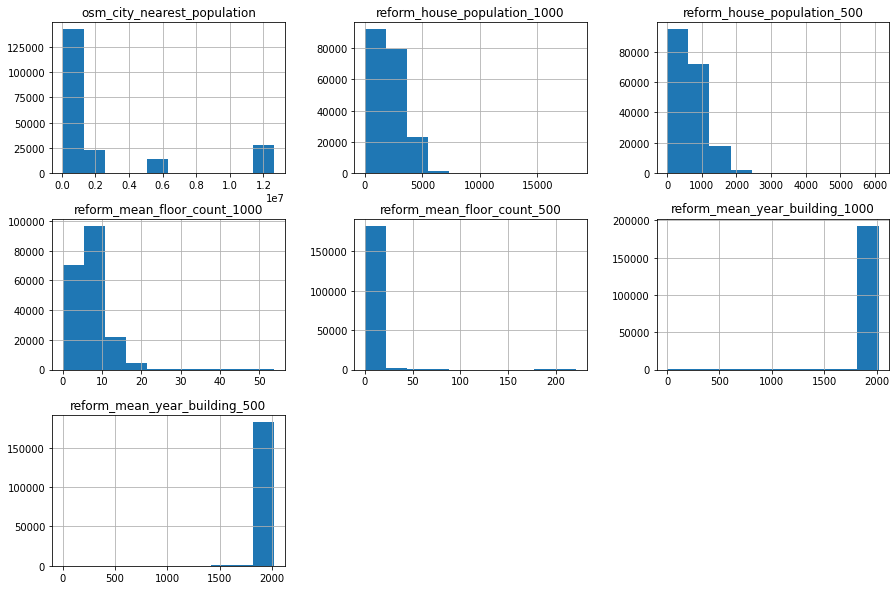

In [567]:
data.drop('floor', axis=1, inplace=True)
bad_columns = bad_columns.drop('floor')
data.filter(bad_columns).hist(figsize=(15, 10));

`reform_house_population` восстановим медианой, по остальным столбцам сложно делать предположения о хорошей импутации, поэтому мы удалим их.

In [568]:
bad_columns = bad_columns.drop(['reform_house_population_1000', 'reform_house_population_500'])
data.drop(bad_columns, axis=1, inplace=True)

In [569]:
data['reform_house_population_1000'].fillna(data['reform_house_population_1000'].dropna().median(), inplace=True)
data['reform_house_population_500'].fillna(data['reform_house_population_500'].dropna().median(), inplace=True)
print("bad columns?", len(data.columns[data.isna().any()]))

bad columns? 0


Столбцы типа `object`?

In [570]:
data.select_dtypes(include=['object']).head(5)

,city,id,osm_city_nearest_name,region,date
0,Ставрополь,COL_65683,Ставрополь,Ставропольский край,2020-02-23
1,Омск,COL_159011,Омск,Омская область,2020-05-24
2,Белгород,COL_205850,Белгород,Белгородская область,2020-06-28
3,Большой Исток,COL_229491,Екатеринбург,Свердловская область,2020-07-19
4,Новосибирск,COL_77283,Новосибирск,Новосибирская область,2020-03-01


In [571]:
data.city.nunique(), data.osm_city_nearest_name.nunique(), data.region.nunique()

(4431, 170, 49)

Есть идея взять топ городов и сделать из них one-hot encoded фичи.

Пример того, что слепо верить в однородность данных нельзя.

In [572]:
((data.city == 'Москва') == (data.osm_city_nearest_name == 'Москва')).value_counts()

True     192192
False     14282
dtype: int64

In [573]:
((data.city == 'Москва') == (data.region == 'Москва')).value_counts()

True     206444
False        30
dtype: int64

In [574]:
data.drop('osm_city_nearest_name', axis=1, inplace=True)
data = data[(data.city == 'Москва') == (data.region == 'Москва')]

К обработке городов еще вернемся.

Все объявления были взяты за 2020 год, можно поделить на зиму, весну и лето

<AxesSubplot:>

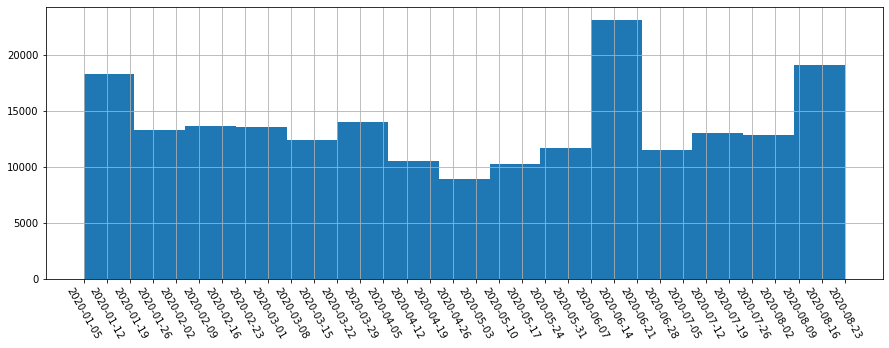

In [575]:
data.date.sort_values().hist(figsize=(15, 5), bins=15, xrot=-60)

In [576]:
data = data.assign(
    date_winter=(data.date < '2020-03-01') * 1.0,
    data_spring=((data.date >= '2020-03-01') & (data.date < '2020-06-01')) * 1.0,
    data_summer=(data.date >= '2020-06-01') * 1.0
)

Как выглядит целевое значение?

In [577]:
data.per_square_meter_price = data.per_square_meter_price.apply(np.log)

count    206444.000000
mean         10.931340
std           1.235372
min           5.965147
25%          10.284137
50%          11.003172
75%          11.690234
max          14.503645
Name: per_square_meter_price, dtype: float64

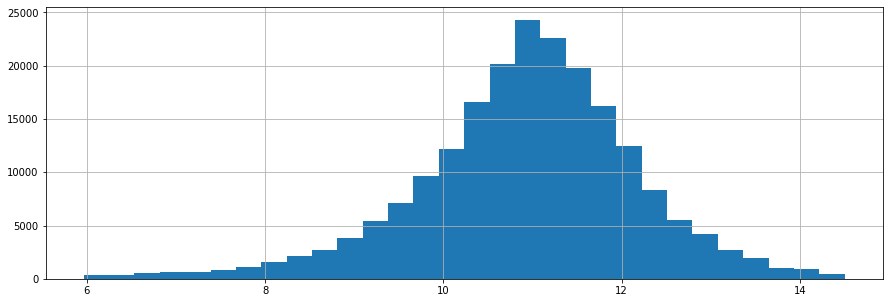

In [578]:
data.per_square_meter_price.hist(figsize=(15, 5), bins=30)
data.per_square_meter_price.describe()

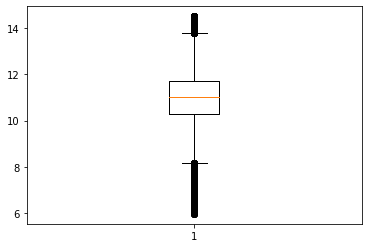

In [579]:
plt.boxplot(data.per_square_meter_price);

Выкинем значение > 14 и < 8 как выбросы.

In [580]:
criteria = (data.per_square_meter_price <= 14) & (data.per_square_meter_price >= 8)
print("drop", (len(data) - criteria.sum()) / len(data) * 100, "percents of rows")
data = data[criteria]

drop 2.8312762783127625 percents of rows


отцентрируем.

In [581]:
data.per_square_meter_price = data.per_square_meter_price.apply(lambda x: x - 11)

count    200599.000000
mean         -0.000544
std           1.082935
min          -2.999796
25%          -0.663432
50%           0.027150
75%           0.691967
max           2.999189
Name: per_square_meter_price, dtype: float64

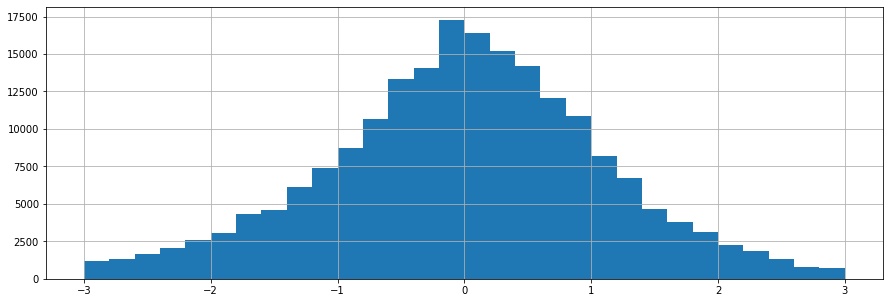

In [582]:
data.per_square_meter_price.hist(figsize=(15, 5), bins=30)
data.per_square_meter_price.describe()

Не похоже на нормальное распределение - присутствуют большие хвосты. Похоже на распределение Коши.

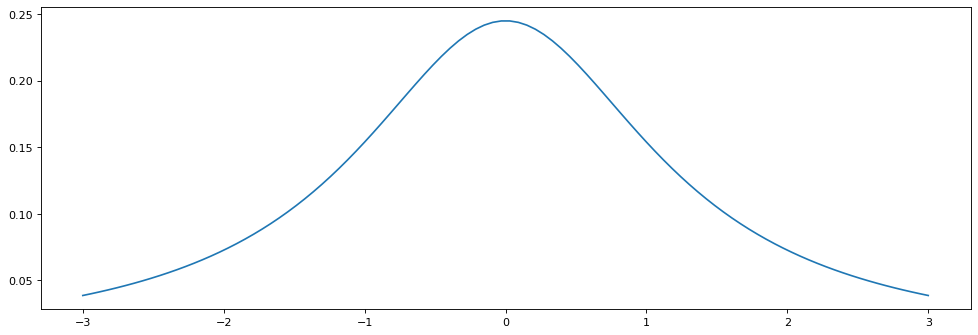

In [583]:
gamma = 1.3
X = np.linspace(-3, 3, 100)
Y = 1 / np.pi * (gamma / (X**2 + gamma**2))
figure(figsize=(15, 5), dpi=80)
plt.plot(X, Y);

In [584]:
cities = data.city.value_counts().head(50).index

In [585]:
print("global mean", data.per_square_meter_price.mean())
means = pd.Series(index=cities, dtype=np.float64)

for city in cities:
    mean = data[data.city == city].per_square_meter_price.mean()
    means[city] = mean

means.sort_values(ascending=False, key=np.abs, inplace=True)
means = means[(np.abs(means) > 0.7)]
print(len(means))
means

global mean -0.0005444172340693414
7


Москва             1.167699
Тольятти          -0.956186
Вологда           -0.937961
Нижний Тагил      -0.801845
Санкт-Петербург    0.762834
Новокузнецк       -0.735356
Волгоград         -0.710842
dtype: float64

In [586]:
for city, _ in means.items():
    col = "city_{}".format(city)
    data[col] = (data.city == city) * 1.0

In [587]:
data['not_Москва'] = (data.city != 'Москва') * 1.0

In [588]:
data.realty_type.value_counts()

10     105948
110     53380
100     41271
Name: realty_type, dtype: int64

In [589]:
data = pd.get_dummies(data, columns=["realty_type"])

In [590]:
data.corr(numeric_only=True).per_square_meter_price.sort_values(ascending=False, key=np.abs)[1:15]

not_Москва                            -0.543900
city_Москва                            0.543900
osm_transport_stop_points_in_0.01      0.505592
osm_transport_stop_points_in_0.0075    0.469933
osm_leisure_points_in_0.01             0.468344
osm_amenity_points_in_0.01             0.456447
osm_crossing_points_in_0.01            0.456076
osm_amenity_points_in_0.0075           0.448213
osm_shops_points_in_0.01               0.444516
osm_healthcare_points_in_0.01          0.436758
osm_amenity_points_in_0.005            0.436163
osm_crossing_points_in_0.0075          0.432484
osm_shops_points_in_0.0075             0.428463
osm_leisure_points_in_0.0075           0.427388
Name: per_square_meter_price, dtype: float64

In [591]:
data.corr(numeric_only=True).per_square_meter_price.sort_values(ascending=False, key=np.abs)[15:30]

osm_catering_points_in_0.01           0.416705
osm_catering_points_in_0.0075         0.415268
osm_healthcare_points_in_0.0075       0.414876
osm_transport_stop_points_in_0.005    0.407390
osm_catering_points_in_0.005          0.407096
osm_shops_points_in_0.005             0.406915
osm_offices_points_in_0.01            0.406576
osm_finance_points_in_0.01            0.402303
osm_crossing_points_in_0.005          0.399773
osm_offices_points_in_0.0075          0.393515
osm_finance_points_in_0.0075          0.386189
osm_healthcare_points_in_0.005        0.381964
osm_offices_points_in_0.005           0.380736
osm_leisure_points_in_0.005           0.378348
osm_amenity_points_in_0.001           0.358616
Name: per_square_meter_price, dtype: float64

In [592]:
data.corr(numeric_only=True).per_square_meter_price.sort_values(ascending=False, key=np.abs)[30:45]

osm_subway_closest_dist         -0.358396
osm_finance_points_in_0.005      0.356216
reform_house_population_1000     0.325692
osm_catering_points_in_0.001     0.322660
osm_historic_points_in_0.01      0.307632
osm_shops_points_in_0.001        0.297537
osm_hotels_points_in_0.01        0.291671
lng                             -0.288064
osm_historic_points_in_0.0075    0.281298
osm_hotels_points_in_0.0075      0.281284
osm_city_closest_dist           -0.277126
osm_hotels_points_in_0.005       0.261861
osm_culture_points_in_0.01       0.259068
osm_culture_points_in_0.0075     0.234914
osm_historic_points_in_0.005     0.234493
Name: per_square_meter_price, dtype: float64

In [593]:
data.filter(['realty_type_10', 'realty_type_100','realty_type_110', 'per_square_meter_price']).corr(numeric_only=True).per_square_meter_price.sort_values(ascending=False, key=np.abs)

per_square_meter_price    1.000000
realty_type_10           -0.160191
realty_type_100           0.103738
realty_type_110           0.086063
Name: per_square_meter_price, dtype: float64

In [594]:
data["osm_transport_stop_points_in_0.01"].describe()

count    200599.000000
mean         21.692451
std          16.136466
min           0.000000
25%           9.000000
50%          19.000000
75%          31.000000
max         108.000000
Name: osm_transport_stop_points_in_0.01, dtype: float64

In [595]:
data["osm_transport_stop_points_in_0.01"] = data["osm_transport_stop_points_in_0.01"].apply(np.sqrt)

In [596]:
data["osm_leisure_points_in_0.01"] = data["osm_leisure_points_in_0.01"].apply(np.sqrt).apply(np.sqrt)

In [597]:
data["osm_crossing_points_in_0.0075"] = data["osm_crossing_points_in_0.0075"].apply(np.sqrt).apply(np.sqrt)

In [598]:
data["osm_shops_points_in_0.001"] = data["osm_shops_points_in_0.001"].apply(np.sqrt).apply(np.sqrt)

In [599]:
data["osm_offices_points_in_0.0075"] = data["osm_offices_points_in_0.0075"].apply(np.sqrt).apply(np.sqrt)

In [600]:
data["osm_finance_points_in_0.01"] = data["osm_finance_points_in_0.01"].apply(np.sqrt).apply(np.sqrt)

In [601]:
data["osm_subway_closest_dist"] = data["osm_subway_closest_dist"].apply(np.sqrt).apply(np.sqrt).apply(np.sqrt)

In [602]:
data["reform_house_population_1000"] = data["reform_house_population_1000"].apply(np.sqrt)

In [603]:
data["osm_train_stop_closest_dist"] = data["osm_train_stop_closest_dist"].apply(np.sqrt).apply(np.sqrt).apply(np.sqrt)

In [604]:
data["osm_healthcare_points_in_0.0075"] = data["osm_healthcare_points_in_0.0075"].apply(np.sqrt).apply(np.sqrt)

In [605]:
data["osm_catering_points_in_0.001"] = data["osm_catering_points_in_0.001"].apply(np.sqrt).apply(np.sqrt)

Попробуем взять топ столбцов, учитывая мультиколлинеарность.

In [606]:
good_columns = [
    'city_Москва',
    #'not_Москва',
    #'city_Тольятти',
    'city_Вологда',
    'city_Нижний Тагил',
    'city_Санкт-Петербург',
    ##'city_Новокузнецк',
    #'city_Волгоград',
    #'city_Омск',
    #'city_Ульяновск',

    'osm_transport_stop_points_in_0.01',
    'osm_leisure_points_in_0.01',
    'osm_crossing_points_in_0.0075', # best
    'osm_shops_points_in_0.001',
    'osm_offices_points_in_0.0075', # best
    'osm_finance_points_in_0.01', # -0.002
    'osm_subway_closest_dist',
    #'reform_house_population_1000',#
    #'osm_hotels_points_in_0.001',
    #'osm_culture_points_in_0.001', # малый вклад
    #'osm_historic_points_in_0.005', # not sure
    'osm_train_stop_closest_dist',
    'osm_healthcare_points_in_0.0075', # best
    #'osm_amenity_points_in_0.005', # but 0.001 good too
    'osm_catering_points_in_0.001',
    #'osm_train_stop_points_in_0.0075', # малый вклад
    #'date_winter',
    #'data_spring',
    #'data_summer',
    'realty_type_10',
    #'realty_type_100',
    #'realty_type_110'
] #+ list("city_{}".format(city) for city in means.index)

In [607]:
#good_columns[-5:]

In [608]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [609]:
X = data.filter(good_columns).to_numpy()
Y = data.per_square_meter_price.to_numpy()

In [610]:
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

In [611]:
len(X)

200599

In [612]:
k = 10000 # 5%
X2 = X[-k:]
Y2 = Y[-k:]
X = X[:k]
Y = Y[:k]

In [613]:
model = SGDRegressor(
    penalty='elasticnet',
    alpha=0.0001,
    l1_ratio=0.3,
    loss='huber',
    epsilon=5, # best huber
    #epsilon=0.6, # best epsilon_insensitive
    learning_rate='invscaling',
    random_state=1337,
    eta0=0.2, #scheduler
    power_t=0.9, #scheduler
    early_stopping=False,
    validation_fraction=0.2,
)
model.fit(X, Y)

SGDRegressor(epsilon=5, eta0=0.2, l1_ratio=0.3, loss='huber',
             penalty='elasticnet', power_t=0.9, random_state=1337,
             validation_fraction=0.2)

In [614]:
score = model.score(X2, Y2)
score

0.49608056355706376

In [615]:
model.coef_

array([ 0.34903451, -0.02676721, -0.005678  ,  0.14171188,  0.03397394,
        0.12732847,  0.11929968,  0.02380519,  0.04102476, -0.02675373,
       -0.12467682, -0.08810687,  0.0434308 ,  0.07844395, -0.08188536])

Предсказываем `per_square_meter_price`

In [616]:
final = pd.read_csv('./data/test_x.csv')

In [617]:
final['reform_house_population_1000'].fillna(final['reform_house_population_1000'].dropna().median(), inplace=True)
final['reform_house_population_500'].fillna(final['reform_house_population_500'].dropna().median(), inplace=True)

In [618]:
for col in good_columns:
    if col in final.columns:
        final[col] = final[col].fillna(final[col].dropna().median())

In [619]:
final = final.assign(
    date_winter=(final.date < '2020-03-01') * 1.0,
    data_spring=((final.date >= '2020-03-01') & (final.date < '2020-06-01')) * 1.0,
    data_summer=(final.date >= '2020-06-01') * 1.0
)

In [620]:
for city, _ in means.items():
    col = "city_{}".format(city)
    final[col] = (final.city == city) * 1.0

In [621]:
final['not_Москва'] = (final.city != 'Москва') * 1.0

In [622]:
if final["osm_transport_stop_points_in_0.01"].isna().sum() == 0:
    final["osm_transport_stop_points_in_0.01"] = final["osm_transport_stop_points_in_0.01"].apply(np.sqrt)
else:
    print("kek")

if final["osm_leisure_points_in_0.01"].isna().sum() == 0:
    final["osm_leisure_points_in_0.01"] = final["osm_leisure_points_in_0.01"].apply(np.sqrt).apply(np.sqrt)
else:
    print("kek2")

if final['osm_crossing_points_in_0.0075'].isna().sum() == 0:
    final["osm_crossing_points_in_0.0075"] = final["osm_crossing_points_in_0.0075"].apply(np.sqrt).apply(np.sqrt)
else:
    print("kek3")

if final['osm_shops_points_in_0.001'].isna().sum() == 0:
    final["osm_shops_points_in_0.001"] = final["osm_shops_points_in_0.001"].apply(np.sqrt).apply(np.sqrt)
else:
    print("kek4")

if final['osm_offices_points_in_0.0075'].isna().sum() == 0:
    final["osm_offices_points_in_0.0075"] = final["osm_offices_points_in_0.0075"].apply(np.sqrt).apply(np.sqrt)
else:
    print("kek5")

if final['osm_finance_points_in_0.01'].isna().sum() == 0:
    final["osm_finance_points_in_0.01"] = final["osm_finance_points_in_0.01"].apply(np.sqrt).apply(np.sqrt)
else:
    print("kek6")

if final["osm_subway_closest_dist"].isna().sum() == 0:
    final["osm_subway_closest_dist"] = final["osm_subway_closest_dist"].apply(np.sqrt).apply(np.sqrt).apply(np.sqrt)
else:
    print("kek7")


if final["reform_house_population_1000"].isna().sum() == 0:
    final["reform_house_population_1000"] = final["reform_house_population_1000"].apply(np.sqrt)
else:
    print("kek8")


if final["osm_train_stop_closest_dist"].isna().sum() == 0:
    final["osm_train_stop_closest_dist"] = final["osm_train_stop_closest_dist"].apply(np.sqrt).apply(np.sqrt).apply(np.sqrt)
else:
    print("kek9")

if final["osm_healthcare_points_in_0.0075"].isna().sum() == 0:
    final["osm_healthcare_points_in_0.0075"] = final["osm_healthcare_points_in_0.0075"].apply(np.sqrt).apply(np.sqrt)
else:
    print("kek10")
    
if final["osm_catering_points_in_0.001"].isna().sum() == 0:
    final["osm_catering_points_in_0.001"] = final["osm_catering_points_in_0.001"].apply(np.sqrt).apply(np.sqrt)
else:
    print("kek11")

In [623]:
final = pd.get_dummies(final, columns=["realty_type"])

In [624]:
X_ = final.filter(good_columns).to_numpy()

In [625]:
sc = StandardScaler()
sc.fit(X_)
X_ = sc.transform(X_)

In [626]:
Y_ = model.predict(X_)

In [627]:
Y_

array([ 1.31986831, -0.81276598, -0.19545338, ...,  0.16247765,
        1.13840923, -0.00297012])

In [628]:
results = pd.DataFrame({
    'per_square_meter_price': Y_,
})

array([[<AxesSubplot:title={'center':'per_square_meter_price'}>]],
      dtype=object)

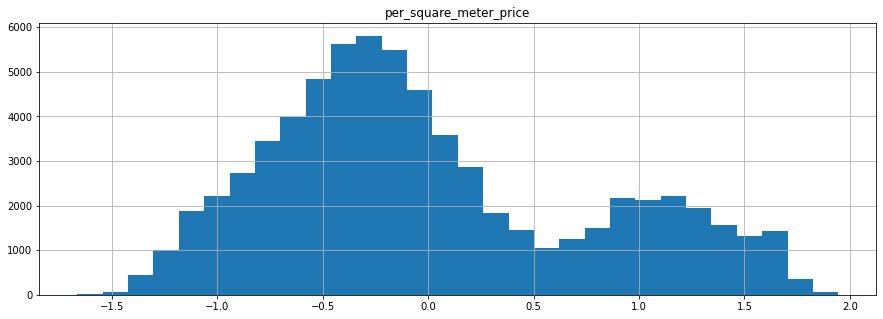

In [629]:
results.hist(figsize=(15, 5), bins=30)

In [630]:
results.per_square_meter_price.describe()

count    68825.000000
mean        -0.000528
std          0.761177
min         -1.664595
25%         -0.545157
50%         -0.169185
75%          0.484633
max          1.945279
Name: per_square_meter_price, dtype: float64

In [631]:
score, mean_absolute_percentage_error(Y2, model.predict(X2)), mean_absolute_percentage_error(np.exp(Y2 + 11), np.exp(model.predict(X2) + 11) / 2)

(0.49608056355706376, 3.80563893908888, 0.6622145480442757)

In [632]:
model.coef_

array([ 0.34903451, -0.02676721, -0.005678  ,  0.14171188,  0.03397394,
        0.12732847,  0.11929968,  0.02380519,  0.04102476, -0.02675373,
       -0.12467682, -0.08810687,  0.0434308 ,  0.07844395, -0.08188536])

In [633]:
results.per_square_meter_price = results.per_square_meter_price.apply(lambda x: np.exp(x + 11))

<AxesSubplot:>

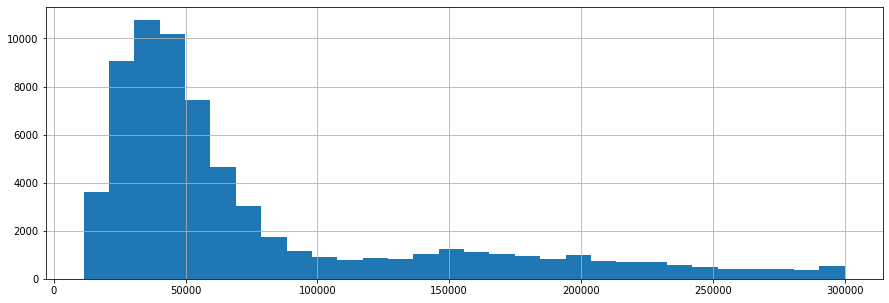

In [634]:
results.per_square_meter_price[results.per_square_meter_price < 300000].hist(figsize=(15, 5), bins=30)

<AxesSubplot:>

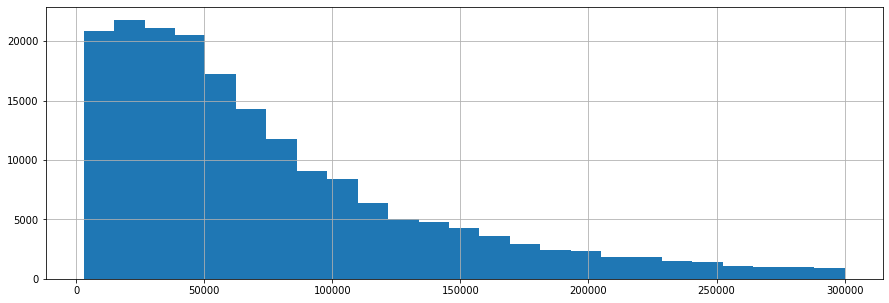

In [635]:
d2 = data.per_square_meter_price.apply(lambda x: np.exp(x + 11))
d2[d2 < 300000].hist(figsize=(15, 5), bins=25)

<AxesSubplot:>

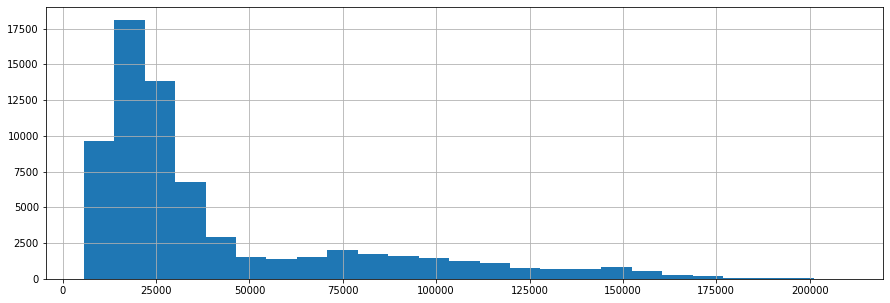

In [636]:
d3 = results.per_square_meter_price.apply(lambda x: x / 2)
d3[d3 < 300000].hist(figsize=(15,5), bins=25)

In [637]:
mean_absolute_percentage_error(np.exp(Y2 + 11), np.exp(model.predict(X2) + 11) / 2)

0.6622145480442757

In [638]:
len(results.per_square_meter_price[results.per_square_meter_price < 0])

0

In [639]:
results.per_square_meter_price = d3

In [640]:
results

,per_square_meter_price
0,112052.314411
1,13280.961706
2,24622.093758
3,18749.723543
4,21787.859290
...,...
68820,11777.381801
68821,18631.970910
68822,35218.629654
68823,93457.498052


In [641]:
results.to_csv("./solution.csv", index_label='id')